In [1]:
from __future__ import division, absolute_import, print_function
%matplotlib inline
import sys
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np
from resonator import background, see, shunt

path1= os.path.abspath('./Data/Without_Atten_On_Input')
path2= os.path.abspath('./Data/With_30dB_Atten_On_Input')

print(path1)
print(path2)

C:\Users\frolovlab\Documents\Python Scripts\msmt\CW\Data\Without_Atten_On_Input
C:\Users\frolovlab\Documents\Python Scripts\msmt\CW\Data\With_30dB_Atten_On_Input


In [19]:
y1 = np.linspace(-60,-20,30)
y2 = np.linspace(-20,20,20)

Q_i_mat = []

for i in range(1,9):
    Q_i_arr = []
    exptname = 'E1_'+str(i)+'R_Single_tone_powerdep.hdf5'
    for j in range(len(y1)):
        with h5py.File(path2+'/'+exptname, 'r') as f:
            data1 = f['S21'][()]
            x_pts = f['Frequency'][()]
        resonator = shunt.LinearShuntFitter(frequency=x_pts, data=data1[j],
                                  background_model=background.MagnitudeSlopeOffsetPhaseDelay() )
        Q_i_arr.append(resonator.Q_i) 
        
    for j in range(len(y2)):
        with h5py.File(path1+'/'+exptname, 'r') as f:
            data1 = f['S21'][()]
            x_pts = f['Frequency'][()]
        resonator = shunt.LinearShuntFitter(frequency=x_pts, data=data1[j],
                                  background_model=background.MagnitudeSlopeOffsetPhaseDelay() )
        Q_i_arr.append(resonator.Q_i)
   

        
    Q_i_mat.append(Q_i_arr)

In [29]:
dat = np.array(Q_i_mat)
y = np.append(y1,y2)

(50,)

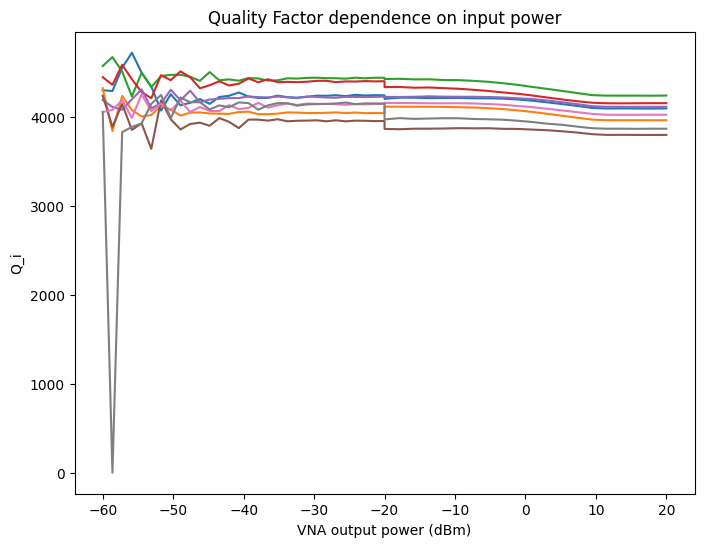

In [30]:
fig = plt.figure(figsize=(8,6))
plt.subplot(111, title="Quality Factor dependence on input power", ylabel="Q_i", xlabel="VNA output power (dBm)")


for i in range(8):
    plt.plot(y,dat[i])

plt.show()

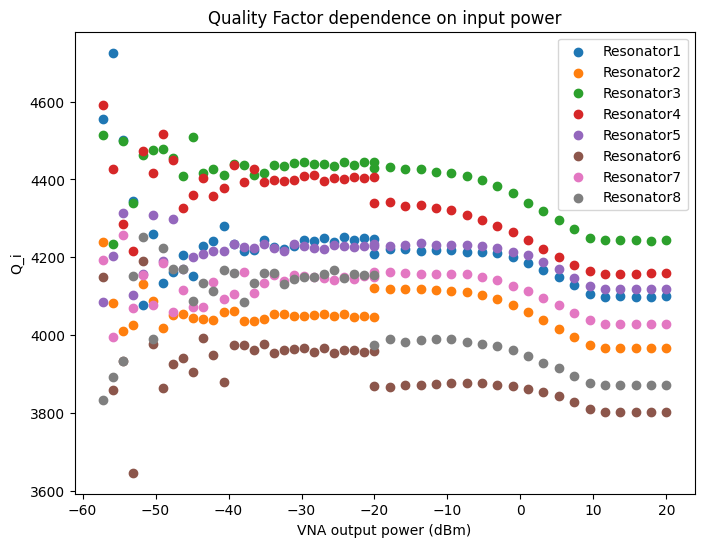

In [39]:
fig = plt.figure(figsize=(8,6))
plt.subplot(111, title="Quality Factor dependence on input power", ylabel="Q_i", xlabel="VNA output power (dBm)")


for i in range(8):
    plt.scatter(y[2:],dat[i][2:], label = 'Resonator'+str(i+1))

plt.legend()
#plt.show()
#plt.savefig('Data/Qi_powerdep.png')

Connected to: Keysight Technologies P9374A (serial:MY57213343, firmware:A.17.35.14) in 0.01s
Connected to: Agilent Technologies N5183B (serial:MY53270913, firmware:B.01.58) in 0.01s


  0%|          | 0/3 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

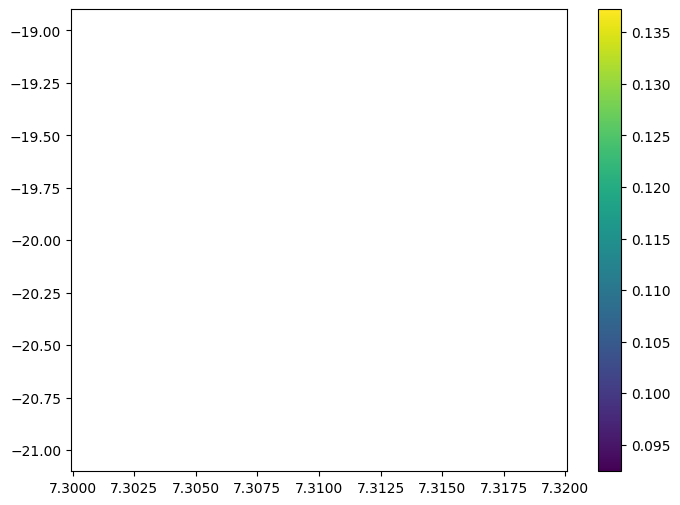

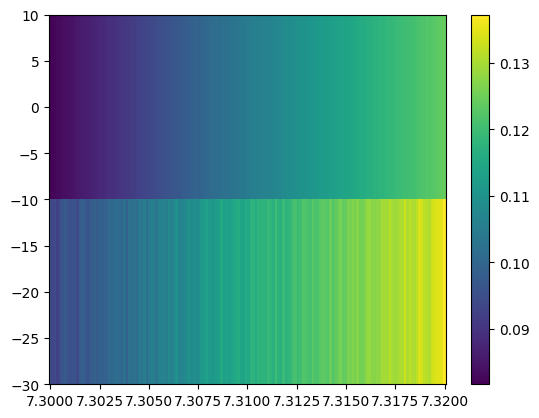

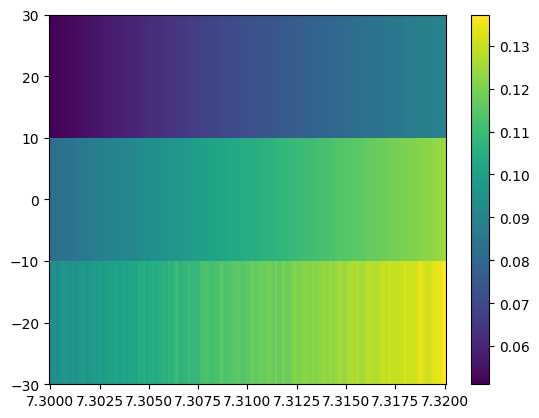

In [4]:
import os
import time
from datetime import datetime
import json

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import h5py
from FrolovLab_RF.helper import get_unique_filename

import qcodes as qc
from qcodes.dataset import Measurement
from qcodes.instrument_drivers.Keysight import KeysightP9374A
from qcodes.instrument_drivers.Keysight.Keysight_N5183B import KeysightN5183B

pna = KeysightP9374A('pna','TCPIP0::localhost::hislip0::INSTR')
mxg = KeysightN5183B('mxg','TCPIP0::192.168.1.140::inst0::INSTR')

path = os.path.abspath('./Data/')
expname = 'test'

filename = get_unique_filename(path,expname, '.hdf5')
figname = get_unique_filename(path,expname, '.png')

# Open the Config file
with open('config.json','r+') as f:
    config = json.load(f)
config['datetime'] = datetime.now().strftime('%Y_%m_%d_%I_%M_%S_%p')

expt_cfg = {'f_start': 7.3e9,
            'f_stop': 7.32e9,
            'f_points': 160,
            'p_start': -20,
            'p_stop': 20,
            'p_points' : 3
            }

x_pts = np.linspace(expt_cfg['f_start'],expt_cfg['f_stop'],expt_cfg['f_points'])
y_pts = np.linspace(expt_cfg['p_start'],expt_cfg['p_stop'],expt_cfg['p_points'])

pna.power(config['pna']['power'])
pna.start(expt_cfg['f_start'])
pna.stop(expt_cfg['f_stop'])
pna.points(expt_cfg['f_points'])
pna.if_bandwidth(config['pna']['if_bandwidth'])
pna.averages_enabled(True)
pna.averages(config['pna']['averages'])

traces = pna.traces
meas = Measurement()
meas.register_parameter(traces.tr1.polar)

# Measure
S21 = traces[0]
data = [1j]
data.clear()

fig = plt.figure(figsize=(8,6))
plt.subplot(111, title="Single Tone - power dependence", xlabel="Frequency (GHz)", ylabel="VNA output power (dBm)")
plt.ioff()

# Save data.
with h5py.File(path+'/'+filename, 'a') as f:
    dset00 = f.create_dataset('Metadata', data = json.dumps(config))
    dset0 = f.create_dataset('Frequency', data = x_pts)
    dset1 = f.create_dataset('Power', data = y_pts)
    dset2 = f.create_dataset('S21', data = data, chunks = True)

y_iter = 0
for y in tqdm(y_pts):
    y_iter += 1
    pna.power(y)
    pna.output(1)
    temp = S21.polar()
    data.append(temp)
    with h5py.File(path+'/'+filename, 'r+') as f:
        f['S21'][:] = data
    plt.clf()
    plt.pcolormesh(x_pts/1e9, y_pts[:y_iter] ,20*np.log10(np.abs(data)))
    plt.colorbar()
    plt.pause(0.05)
    pna.output(0)
    pna.sweep_mode("CONT")
    
plt.savefig(path+'/'+figname)

# Close the connected instrument
pna.close()
mxg.close()
    